# LSTM Prediction

## Package dependencies

In [1]:
import re
import ast
import torch
import random
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Set random seeds to ensure reproducible results

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Check whether CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading DATA

In [3]:
# Read forex price data and sentiment data
forex_data = pd.read_csv('E:/zuoye/PROJECT_1/Forex_DATA/eurusd_forex_data.csv')
sentiment_data = pd.read_excel('E:/zuoye/PROJECT_1/Sentiment_NEWS/weighted_sentiments_by_day.xlsx')


# Convert the Date column to datetime and ensure both datasets use the same time zone
forex_data['Date'] = pd.to_datetime(forex_data['Date']).dt.tz_localize(None)  
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date']).dt.tz_localize(None) 

# Set Date as index before merging
forex_data.set_index('Date', inplace=True)
sentiment_data.set_index('Date', inplace=True)

# Use outer join to ensure all unique dates are retained
total_dates = pd.date_range(start=min(forex_data.index.min(), sentiment_data.index.min()), 
                            end=max(forex_data.index.max(), sentiment_data.index.max()), freq='D')

# Reindex to fill in any missing dates and merge
forex_data = forex_data.reindex(total_dates).rename_axis('Date').reset_index()
sentiment_data = sentiment_data.reindex(total_dates).rename_axis('Date').reset_index()

# Merge the datasets based on date
merged_data = pd.merge(forex_data, sentiment_data, on='Date', how='outer').sort_values(by='Date').fillna(method='ffill')

# Make sure 'Date' is the index again
merged_data.set_index('Date', inplace=True)

C:\Users\THUNDEROBOT\AppData\Local\Temp\ipykernel_12920\2981289988.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = pd.merge(forex_data, sentiment_data, on='Date', how='outer').sort_values(by='Date').fillna(method='ffill')


## Calculate relative currency sentiment (EUR sentiment - USD sentiment)

In [4]:
merged_data['relative_pos_sentiment'] = merged_data['eur_positive'] - merged_data['usd_positive']
merged_data['relative_neu_sentiment'] = merged_data['eur_neutral'] - merged_data['usd_neutral']
merged_data['relative_neg_sentiment'] = merged_data['eur_negative'] - merged_data['usd_negative']

# Set the size of the sliding window

In [5]:
window_size = 5

# Create a list of lag columns to add
lagged_columns_tech_only = []
lagged_columns_with_sentiment = []

# Create a sliding window feature that uses previous days' data to predict prices for the next 1 day
for i in range(1, window_size + 1):
    # Lag value of technical indicators
    lagged_columns_tech_only.extend([
        merged_data['Open'].shift(i).rename(f'Open_lag_{i}'),
        merged_data['High'].shift(i).rename(f'High_lag_{i}'),
        merged_data['Low'].shift(i).rename(f'Low_lag_{i}'),
        merged_data['Close'].shift(i).rename(f'Close_lag_{i}'),  # 添加 Close 的滞后值
    ])
    
    # Lag value of technology + emotion indicator (for technology + emotion model)
    lagged_columns_with_sentiment.extend([
        merged_data['Open'].shift(i).rename(f'Open_lag_{i}'),
        merged_data['High'].shift(i).rename(f'High_lag_{i}'),
        merged_data['Low'].shift(i).rename(f'Low_lag_{i}'),
        merged_data['Close'].shift(i).rename(f'Close_lag_{i}'),  # 添加 Close 的滞后值
        merged_data['relative_pos_sentiment'].shift(i).rename(f'relative_pos_sentiment_lag_{i}'),
        merged_data['relative_neu_sentiment'].shift(i).rename(f'relative_neu_sentiment_lag_{i}'),
        merged_data['relative_neg_sentiment'].shift(i).rename(f'relative_neg_sentiment_lag_{i}')
    ])

# Create target column
merged_data['target_next_day'] = merged_data['Close'].shift(-1)

# Concatenate technology model data sets
merged_data_tech_only = pd.concat(lagged_columns_tech_only, axis=1).join(merged_data['target_next_day']).dropna()

# Splicing technology + emotion model data set
merged_data_with_sentiment = pd.concat(lagged_columns_with_sentiment, axis=1).join(merged_data['target_next_day']).dropna()

# Generate the final technical and technical + emotional data set
# Pure technical indicators data set
technical_columns = [col for col in merged_data_tech_only.columns if 'sentiment' not in col and
                     'eur' not in col and 'Adj Close' not in col and col != 'Close']
merged_data_technical = merged_data_tech_only[technical_columns]

# Technology + emotional data set
merged_data_all = merged_data_with_sentiment.copy()

In [6]:
print(merged_data_technical.columns)

Index(['Open_lag_1', 'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Open_lag_2',
       'High_lag_2', 'Low_lag_2', 'Close_lag_2', 'Open_lag_3', 'High_lag_3',
       'Low_lag_3', 'Close_lag_3', 'Open_lag_4', 'High_lag_4', 'Low_lag_4',
       'Close_lag_4', 'Open_lag_5', 'High_lag_5', 'Low_lag_5', 'Close_lag_5',
       'target_next_day'],
      dtype='object')


In [7]:
# View the spliced pure technical data set
print("Technical Indicators data set (technical features only):")
print(merged_data_technical.head())

# View the spliced technical + emotional dataset
print("\n Technology + Sentiment data set (including technical and emotional characteristics):")
print(merged_data_all.head())


Technical Indicators data set (technical features only):
            Open_lag_1  High_lag_1  Low_lag_1  Close_lag_1  Open_lag_2  \
Date                                                                     
2018-09-26    1.175323    1.179245   1.173254     1.175295    1.175102   
2018-09-27    1.176609    1.177700   1.172897     1.176318    1.175323   
2018-09-28    1.174715    1.175917   1.166453     1.174853    1.176609   
2018-09-29    1.163684    1.165300   1.157059     1.163738    1.174715   
2018-09-30    1.163684    1.165300   1.157059     1.163738    1.163684   

            High_lag_2  Low_lag_2  Close_lag_2  Open_lag_3  High_lag_3  ...  \
Date                                                                    ...   
2018-09-26    1.181502   1.172525     1.175102    1.177607    1.180164  ...   
2018-09-27    1.179245   1.173254     1.175295    1.175102    1.181502  ...   
2018-09-28    1.177700   1.172897     1.176318    1.175323    1.179245  ...   
2018-09-29    1.175917   1.16

# Define data preparation functions

In [8]:
def prepare_data_for_cv(data):
    feature_columns = [col for col in data.columns if 'lag' in col]
    # Prepare features and objectives
    X = data[feature_columns].values
    y = data['target_next_day'].values
    dates = data.index


    # Create sliding window features and targets
    def create_sliding_windows(X, y, dates, window_size):
        X_windows, y_windows, date_windows = [], [], []
        for i in range(len(X) - window_size):
            X_windows.append(X[i:i + window_size])
            y_windows.append(y[i + window_size])
            date_windows.append(dates[i + window_size])
        return np.array(X_windows), np.array(y_windows), np.array(date_windows)

    X_windows, y_windows, date_windows = create_sliding_windows(X, y, dates, window_size)

    return X_windows, y_windows, date_windows

# only technical data
X_windows_tech, y_windows_tech, dates_windows_tech = prepare_data_for_cv(merged_data_technical)

# data with technical and emotional indicators
X_windows_all, y_windows_all, dates_windows_all = prepare_data_for_cv(merged_data_all)

## Define the LSTM model

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output a predicted closing price
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Takes the output of the last time step
        return self.fc(lstm_out)

## Define the Evaluation index calculation function

In [10]:
def compute_metrics(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true))  # MAPE
    mae = mean_absolute_error(y_true, y_pred)   # MAE
    mse = mean_squared_error(y_true, y_pred)  # MSE
    rmse = np.sqrt(mse)  # RMSE
    theils_u = np.sqrt(np.mean(np.square(y_true - y_pred))) / (
        np.sqrt(np.mean(np.square(y_true))) + np.sqrt(np.mean(np.square(y_pred)))
    )  # Theil's U

    # When the error is less than 1%, the Accuracy is calculated
    threshold = 0.005
    accuracy = np.mean(np.abs((y_true - y_pred) / y_true) < threshold)
    return {
        "MAPE": mape, "MAE": mae, "MSE": mse,
        "RMSE": rmse, "Theil's U": theils_u, "Accuracy": accuracy
    }

## Define cross-validation training and evaluation functions

In [11]:
def cross_validate_model(X_windows, y_windows, scaler_y, model_name):
    tscv = TimeSeriesSplit(n_splits=10)
    metrics_list = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_windows)):
        print(f"\n[{model_name}] Fold {fold + 1}/{tscv.get_n_splits()}")

        # Divide the training set and the verification set
        X_train_fold, X_val_fold = X_windows[train_index], X_windows[val_index]
        y_train_fold, y_val_fold = y_windows[train_index], y_windows[val_index]

        # The features are normalized
        scaler_X = MinMaxScaler()
        X_train_fold_scaled = scaler_X.fit_transform(
            X_train_fold.reshape(-1, X_train_fold.shape[-1])
        ).reshape(X_train_fold.shape)
        X_val_fold_scaled = scaler_X.transform(
            X_val_fold.reshape(-1, X_val_fold.shape[-1])
        ).reshape(X_val_fold.shape)

        # The target is normalized
        y_train_fold_scaled = scaler_y.fit_transform(y_train_fold.reshape(-1, 1)).flatten()
        y_val_fold_scaled = scaler_y.transform(y_val_fold.reshape(-1, 1)).flatten()

        # Convert to a tensor
        X_train_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_fold_scaled, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val_fold_scaled, dtype=torch.float32).to(device)

        
        input_size = X_train_tensor.shape[2]
        hidden_size = 128   
        num_layers = 1
        dropout = 0.3
        learning_rate = 1e-3
        batch_size = 32
        weight_decay = 1e-4
        epochs = 100  

        model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)

        # Define loss functions and Adam optimizers
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

        # Build the data loader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )

        # Training model
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze(), y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.6f}")

        # Validation Model
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            y_val_pred_np = y_val_pred.cpu().numpy()
            y_val_pred_inverse = scaler_y.inverse_transform(y_val_pred_np.reshape(-1, 1)).flatten()
            y_val_inverse = scaler_y.inverse_transform(y_val_fold_scaled.reshape(-1, 1)).flatten()

        # Calculation evaluation index
        metrics = compute_metrics(y_val_inverse, y_val_pred_inverse)
        metrics_list.append(metrics)

    # Summary evaluation index
    avg_metrics = {metric: np.mean([fold_metrics[metric] for fold_metrics in metrics_list]) for metric in metrics_list[0]}

    # Print average evaluation metrics
    print(f"\n[{model_name}] Cross-Validation Metrics:")
    for key, value in avg_metrics.items():
        print(f"{key}: {value:.6f}")

    return avg_metrics, model, scaler_X  

# Initializes the normalization of the target value
scaler_y_tech = MinMaxScaler()
scaler_y_all = MinMaxScaler()

# Fits the normalizer over the entire target value
scaler_y_tech.fit(y_windows_tech.reshape(-1, 1))
scaler_y_all.fit(y_windows_all.reshape(-1, 1))

# Divide the test set (keep the last 10% of the data)
test_size_tech = int(len(X_windows_tech) * 0.2)
X_train_val_tech = X_windows_tech[:-test_size_tech]
y_train_val_tech = y_windows_tech[:-test_size_tech]
dates_train_val_tech = dates_windows_tech[:-test_size_tech]

X_test_tech = X_windows_tech[-test_size_tech:]
y_test_tech = y_windows_tech[-test_size_tech:]
dates_test_tech = dates_windows_tech[-test_size_tech:]

test_size_all = int(len(X_windows_all) * 0.2)
X_train_val_all = X_windows_all[:-test_size_all]
y_train_val_all = y_windows_all[:-test_size_all]
dates_train_val_all = dates_windows_all[:-test_size_all]

X_test_all = X_windows_all[-test_size_all:]
y_test_all = y_windows_all[-test_size_all:]
dates_test_all = dates_windows_all[-test_size_all:]

# The model with only technical indicators is cross-validated
metrics_tech_cv, model_tech, scaler_X_tech = cross_validate_model(
    X_train_val_tech, y_train_val_tech, scaler_y_tech,
    model_name='Technical Indicators Only'
)

# Models containing technical and emotional indicators are cross-validated
metrics_all_cv, model_all, scaler_X_all = cross_validate_model(
    X_train_val_all, y_train_val_all, scaler_y_all,
    model_name='Technical + Sentiment Indicators'
)


[Technical Indicators Only] Fold 1/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.028189
Epoch 20/100, Train Loss: 0.027548
Epoch 30/100, Train Loss: 0.023476
Epoch 40/100, Train Loss: 0.020594
Epoch 50/100, Train Loss: 0.023313
Epoch 60/100, Train Loss: 0.020782
Epoch 70/100, Train Loss: 0.019430
Epoch 80/100, Train Loss: 0.019223
Epoch 90/100, Train Loss: 0.018085
Epoch 100/100, Train Loss: 0.015950

[Technical Indicators Only] Fold 2/10
Epoch 10/100, Train Loss: 0.025830


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/100, Train Loss: 0.023989
Epoch 30/100, Train Loss: 0.023566
Epoch 40/100, Train Loss: 0.022142
Epoch 50/100, Train Loss: 0.020682
Epoch 60/100, Train Loss: 0.018188
Epoch 70/100, Train Loss: 0.018285
Epoch 80/100, Train Loss: 0.019103
Epoch 90/100, Train Loss: 0.017085
Epoch 100/100, Train Loss: 0.017535

[Technical Indicators Only] Fold 3/10
Epoch 10/100, Train Loss: 0.019521


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/100, Train Loss: 0.017401
Epoch 30/100, Train Loss: 0.016976
Epoch 40/100, Train Loss: 0.014721
Epoch 50/100, Train Loss: 0.013209
Epoch 60/100, Train Loss: 0.013056
Epoch 70/100, Train Loss: 0.012713
Epoch 80/100, Train Loss: 0.012179
Epoch 90/100, Train Loss: 0.011469
Epoch 100/100, Train Loss: 0.011249

[Technical Indicators Only] Fold 4/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.017519
Epoch 20/100, Train Loss: 0.015973
Epoch 30/100, Train Loss: 0.014545
Epoch 40/100, Train Loss: 0.012753
Epoch 50/100, Train Loss: 0.011744
Epoch 60/100, Train Loss: 0.011696
Epoch 70/100, Train Loss: 0.010789
Epoch 80/100, Train Loss: 0.010608
Epoch 90/100, Train Loss: 0.010082
Epoch 100/100, Train Loss: 0.009822

[Technical Indicators Only] Fold 5/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.009509
Epoch 20/100, Train Loss: 0.008858
Epoch 30/100, Train Loss: 0.008255
Epoch 40/100, Train Loss: 0.007574
Epoch 50/100, Train Loss: 0.007148
Epoch 60/100, Train Loss: 0.006766
Epoch 70/100, Train Loss: 0.006436
Epoch 80/100, Train Loss: 0.005965
Epoch 90/100, Train Loss: 0.005857
Epoch 100/100, Train Loss: 0.005675

[Technical Indicators Only] Fold 6/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Train Loss: 0.008565
Epoch 20/100, Train Loss: 0.007870
Epoch 30/100, Train Loss: 0.007220
Epoch 40/100, Train Loss: 0.006294
Epoch 50/100, Train Loss: 0.006102
Epoch 60/100, Train Loss: 0.005069
Epoch 70/100, Train Loss: 0.005200
Epoch 80/100, Train Loss: 0.004942
Epoch 90/100, Train Loss: 0.005745
Epoch 100/100, Train Loss: 0.004889

[Technical Indicators Only] Fold 7/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.007206
Epoch 20/100, Train Loss: 0.006855
Epoch 30/100, Train Loss: 0.005841
Epoch 40/100, Train Loss: 0.006294
Epoch 50/100, Train Loss: 0.004848
Epoch 60/100, Train Loss: 0.005046
Epoch 70/100, Train Loss: 0.004543
Epoch 80/100, Train Loss: 0.004412
Epoch 90/100, Train Loss: 0.004176
Epoch 100/100, Train Loss: 0.004668

[Technical Indicators Only] Fold 8/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.007445
Epoch 20/100, Train Loss: 0.006639
Epoch 30/100, Train Loss: 0.005810
Epoch 40/100, Train Loss: 0.005260
Epoch 50/100, Train Loss: 0.004819
Epoch 60/100, Train Loss: 0.005363
Epoch 70/100, Train Loss: 0.004077
Epoch 80/100, Train Loss: 0.004344
Epoch 90/100, Train Loss: 0.003656
Epoch 100/100, Train Loss: 0.003850

[Technical Indicators Only] Fold 9/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.007295
Epoch 20/100, Train Loss: 0.005943
Epoch 30/100, Train Loss: 0.005250
Epoch 40/100, Train Loss: 0.004545
Epoch 50/100, Train Loss: 0.004361
Epoch 60/100, Train Loss: 0.004659
Epoch 70/100, Train Loss: 0.003992
Epoch 80/100, Train Loss: 0.003992
Epoch 90/100, Train Loss: 0.003934
Epoch 100/100, Train Loss: 0.003663

[Technical Indicators Only] Fold 10/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.003915
Epoch 20/100, Train Loss: 0.003293
Epoch 30/100, Train Loss: 0.002991
Epoch 40/100, Train Loss: 0.002619
Epoch 50/100, Train Loss: 0.002509
Epoch 60/100, Train Loss: 0.002407
Epoch 70/100, Train Loss: 0.002274
Epoch 80/100, Train Loss: 0.002324
Epoch 90/100, Train Loss: 0.002246
Epoch 100/100, Train Loss: 0.002199

[Technical Indicators Only] Cross-Validation Metrics:
MAPE: 0.004376
MAE: 0.004911
MSE: 0.000044
RMSE: 0.006252
Theil's U: 0.002785
Accuracy: 0.672059

[Technical + Sentiment Indicators] Fold 1/10
Epoch 10/100, Train Loss: 0.023653
Epoch 20/100, Train Loss: 0.021065


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 30/100, Train Loss: 0.015481
Epoch 40/100, Train Loss: 0.013135
Epoch 50/100, Train Loss: 0.012915
Epoch 60/100, Train Loss: 0.011295
Epoch 70/100, Train Loss: 0.013301
Epoch 80/100, Train Loss: 0.010507
Epoch 90/100, Train Loss: 0.010905
Epoch 100/100, Train Loss: 0.009215

[Technical + Sentiment Indicators] Fold 2/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.025022
Epoch 20/100, Train Loss: 0.023528
Epoch 30/100, Train Loss: 0.020893
Epoch 40/100, Train Loss: 0.018854
Epoch 50/100, Train Loss: 0.018298
Epoch 60/100, Train Loss: 0.016683
Epoch 70/100, Train Loss: 0.015355
Epoch 80/100, Train Loss: 0.015642
Epoch 90/100, Train Loss: 0.015073
Epoch 100/100, Train Loss: 0.014594

[Technical + Sentiment Indicators] Fold 3/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.019400
Epoch 20/100, Train Loss: 0.015392
Epoch 30/100, Train Loss: 0.014561
Epoch 40/100, Train Loss: 0.013382
Epoch 50/100, Train Loss: 0.012537
Epoch 60/100, Train Loss: 0.011494
Epoch 70/100, Train Loss: 0.011146
Epoch 80/100, Train Loss: 0.010711
Epoch 90/100, Train Loss: 0.009994
Epoch 100/100, Train Loss: 0.010169

[Technical + Sentiment Indicators] Fold 4/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.016525
Epoch 20/100, Train Loss: 0.013683
Epoch 30/100, Train Loss: 0.011712
Epoch 40/100, Train Loss: 0.010877
Epoch 50/100, Train Loss: 0.010248
Epoch 60/100, Train Loss: 0.009819
Epoch 70/100, Train Loss: 0.010851
Epoch 80/100, Train Loss: 0.008767
Epoch 90/100, Train Loss: 0.009635
Epoch 100/100, Train Loss: 0.008312

[Technical + Sentiment Indicators] Fold 5/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.009250
Epoch 20/100, Train Loss: 0.008232
Epoch 30/100, Train Loss: 0.007635
Epoch 40/100, Train Loss: 0.007121
Epoch 50/100, Train Loss: 0.006661
Epoch 60/100, Train Loss: 0.006527
Epoch 70/100, Train Loss: 0.006180
Epoch 80/100, Train Loss: 0.006402
Epoch 90/100, Train Loss: 0.005891
Epoch 100/100, Train Loss: 0.005996

[Technical + Sentiment Indicators] Fold 6/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Train Loss: 0.007638
Epoch 20/100, Train Loss: 0.006244
Epoch 30/100, Train Loss: 0.006062
Epoch 40/100, Train Loss: 0.005029
Epoch 50/100, Train Loss: 0.006167
Epoch 60/100, Train Loss: 0.004843
Epoch 70/100, Train Loss: 0.004384
Epoch 80/100, Train Loss: 0.005380
Epoch 90/100, Train Loss: 0.004834
Epoch 100/100, Train Loss: 0.005696

[Technical + Sentiment Indicators] Fold 7/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.006850
Epoch 20/100, Train Loss: 0.005743
Epoch 30/100, Train Loss: 0.005156
Epoch 40/100, Train Loss: 0.005184
Epoch 50/100, Train Loss: 0.004800
Epoch 60/100, Train Loss: 0.004369
Epoch 70/100, Train Loss: 0.004300
Epoch 80/100, Train Loss: 0.004575
Epoch 90/100, Train Loss: 0.004105
Epoch 100/100, Train Loss: 0.003924

[Technical + Sentiment Indicators] Fold 8/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.007072
Epoch 20/100, Train Loss: 0.006099
Epoch 30/100, Train Loss: 0.005459
Epoch 40/100, Train Loss: 0.004850
Epoch 50/100, Train Loss: 0.004302
Epoch 60/100, Train Loss: 0.004247
Epoch 70/100, Train Loss: 0.004045
Epoch 80/100, Train Loss: 0.003812
Epoch 90/100, Train Loss: 0.003703
Epoch 100/100, Train Loss: 0.003447

[Technical + Sentiment Indicators] Fold 9/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.007078
Epoch 20/100, Train Loss: 0.005741
Epoch 30/100, Train Loss: 0.004889
Epoch 40/100, Train Loss: 0.004549
Epoch 50/100, Train Loss: 0.004468
Epoch 60/100, Train Loss: 0.003905
Epoch 70/100, Train Loss: 0.004076
Epoch 80/100, Train Loss: 0.003653
Epoch 90/100, Train Loss: 0.003556
Epoch 100/100, Train Loss: 0.003459

[Technical + Sentiment Indicators] Fold 10/10


C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10/100, Train Loss: 0.003723
Epoch 20/100, Train Loss: 0.003080
Epoch 30/100, Train Loss: 0.002780
Epoch 40/100, Train Loss: 0.002772
Epoch 50/100, Train Loss: 0.002457
Epoch 60/100, Train Loss: 0.002382
Epoch 70/100, Train Loss: 0.002408
Epoch 80/100, Train Loss: 0.002409
Epoch 90/100, Train Loss: 0.002155
Epoch 100/100, Train Loss: 0.002233

[Technical + Sentiment Indicators] Cross-Validation Metrics:
MAPE: 0.004821
MAE: 0.005420
MSE: 0.000055
RMSE: 0.006920
Theil's U: 0.003079
Accuracy: 0.630882


## Evaluate the model on the test set


[Technical Only] Test Set Metrics:
MAPE: 0.004140
MAE: 0.004974
MSE: 0.000038
RMSE: 0.006142
Theil's U: 0.002554
Accuracy: 0.661376


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

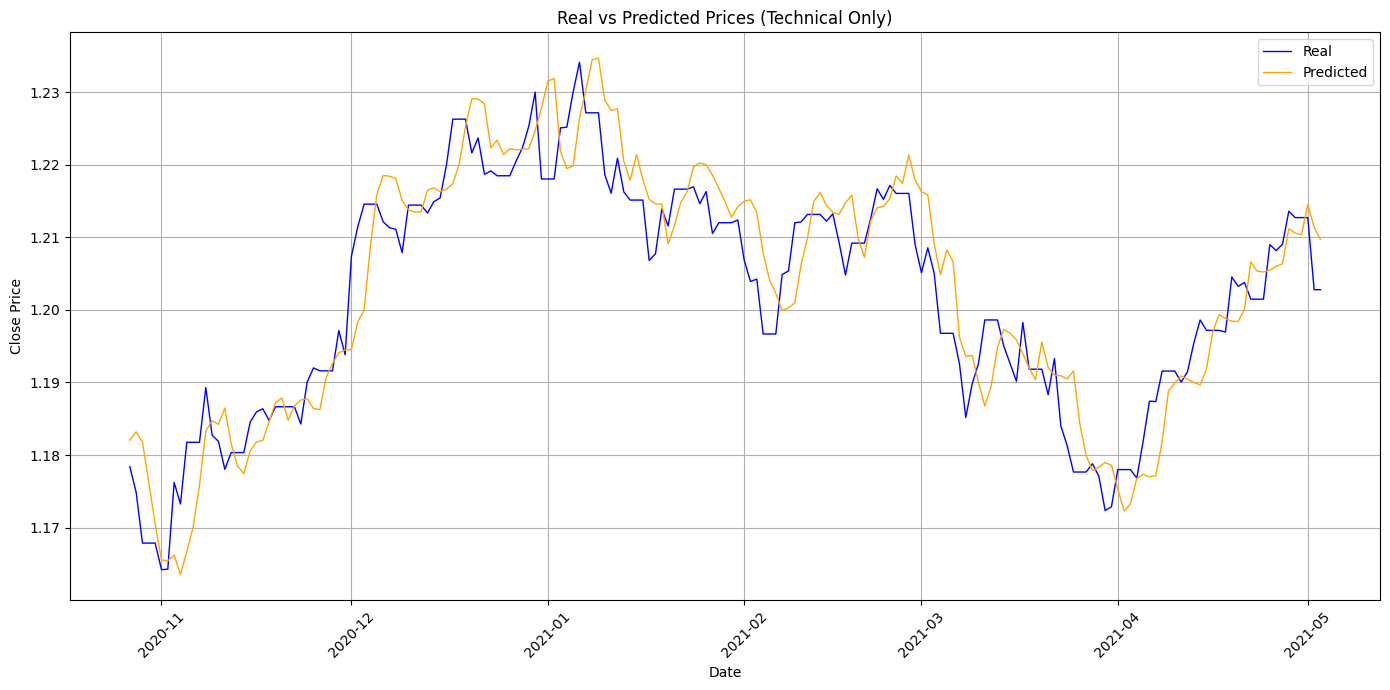


[Technical + Sentiment Indicators] Test Set Metrics:
MAPE: 0.003934
MAE: 0.004725
MSE: 0.000035
RMSE: 0.005924
Theil's U: 0.002463
Accuracy: 0.698413


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

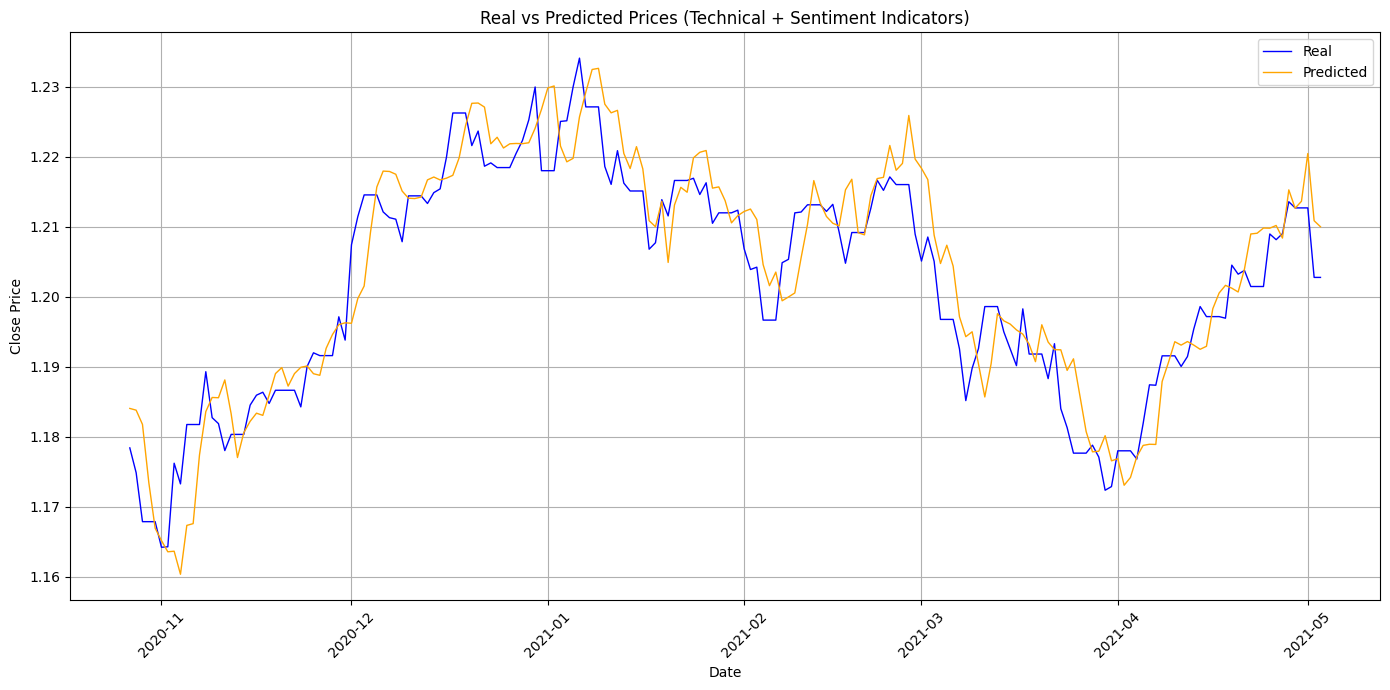

In [12]:
def evaluate_on_test_set(model, scaler_X, scaler_y, X_test, y_test, dates_test, model_name):
    X_test_scaled = scaler_X.transform(
        X_test.reshape(-1, X_test.shape[-1])
    ).reshape(X_test.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

    # model evaluation
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)
        y_test_pred_np = y_test_pred.cpu().numpy()
        y_test_pred_inverse = scaler_y.inverse_transform(y_test_pred_np.reshape(-1, 1)).flatten()
        y_test_inverse = scaler_y.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1)).flatten()

    # Calculation evaluation index
    metrics = compute_metrics(y_test_inverse, y_test_pred_inverse)

    # Print evaluation results
    print(f"\n[{model_name}] Test Set Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.6f}")
        plt.figure(figsize=(14, 7))
    plt.plot(
        dates_test, y_test_inverse, label='Real',
        color='blue', linewidth=1
    )
    plt.plot(
        dates_test, y_test_pred_inverse, label='Predicted',
        color='orange', linewidth=1
    )
    plt.title(f'Real vs Predicted Prices ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()

    return metrics

# Evaluate the model using only technical metrics on the test set
metrics_tech_test = evaluate_on_test_set(
    model_tech, scaler_X_tech, scaler_y_tech,
    X_test_tech, y_test_tech, dates_test_tech,
    model_name='Technical Only'
)

# Evaluate the model with technical and emotional metrics on the test set
metrics_all_test = evaluate_on_test_set(
    model_all, scaler_X_all, scaler_y_all,
    X_test_all, y_test_all, dates_test_all,
    model_name='Technical + Sentiment Indicators'
)


[Technical Only] Test Set Metrics:
MAPE: 0.004140
MAE: 0.004974
MSE: 0.000038
RMSE: 0.006142
Theil's U: 0.002554
Accuracy: 0.661376


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

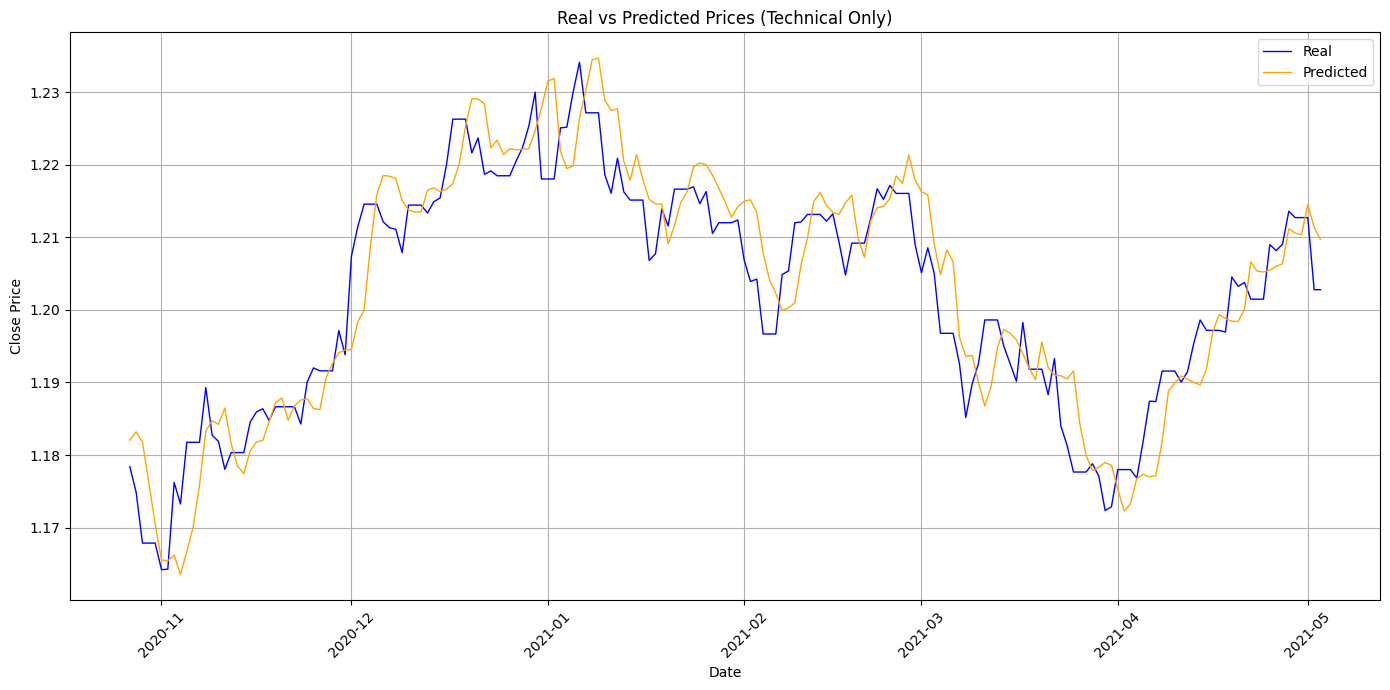


[Technical + Sentiment Indicators] Test Set Metrics:
MAPE: 0.003934
MAE: 0.004725
MSE: 0.000035
RMSE: 0.005924
Theil's U: 0.002463
Accuracy: 0.698413


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

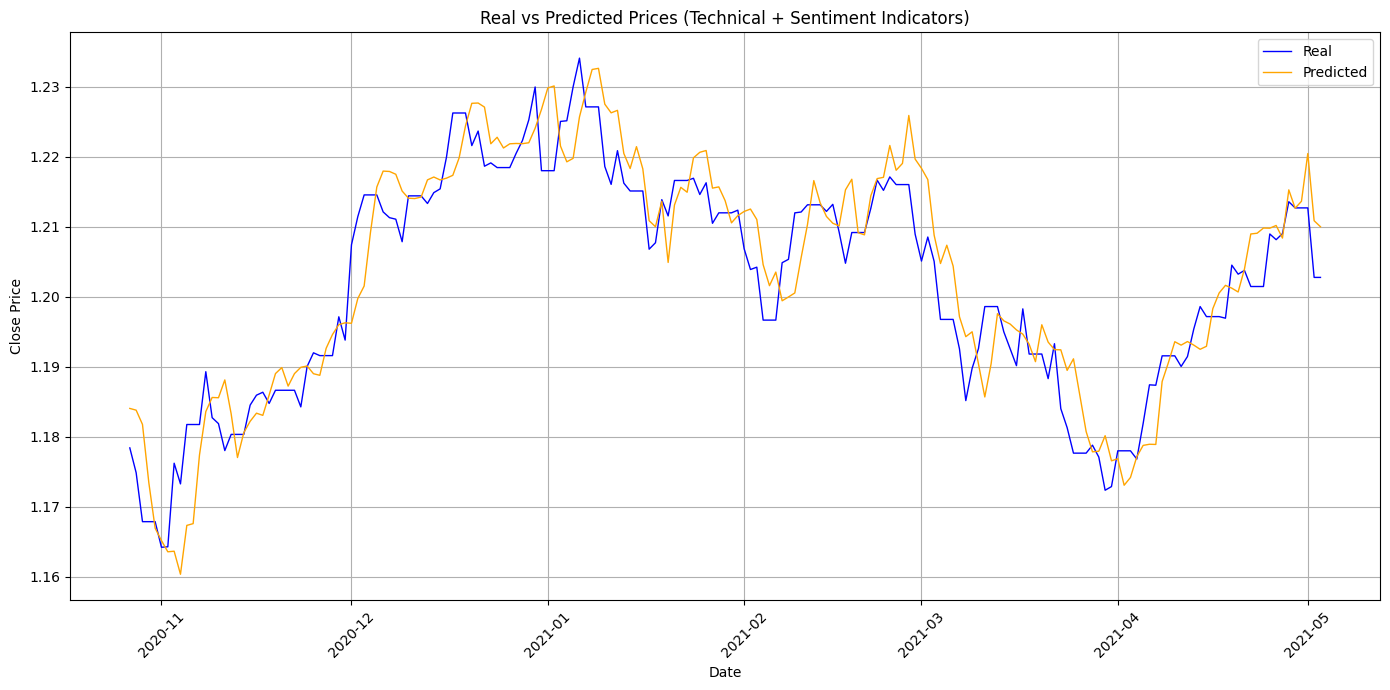

In [13]:
# Evaluate the model using only technical metrics on the test set
metrics_tech_test = evaluate_on_test_set(
    model_tech, scaler_X_tech, scaler_y_tech,
    X_test_tech, y_test_tech, dates_test_tech,
    model_name='Technical Only'
)

# Evaluate the model with technical and emotional metrics on the test set
metrics_all_test = evaluate_on_test_set(
    model_all, scaler_X_all, scaler_y_all,
    X_test_all, y_test_all, dates_test_all,
    model_name='Technical + Sentiment Indicators'
)